# ML Assignment 7.2

**Objective: To learn how to train and predict a soft margin-SVM with RBF kernel using SMO algorithm.**

1. Using the **Cleveland dataset** of heart disease with the following pre-processing and instructions:

> Use only two features for simplicity : 
    - age (data in column #1)
    - trestbps (data in column #4)

> Modify the last column (# 14) 
    - from 1 (heart disease) & 0 (no heart disease) 
    - to Y(i)= {1 and -1}.

> Apply feature scaling methods to the data of Col# 1 and Col# 4.

> Use 70% data for training and 30% for testing.


------

### Importing Required Headers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import copy
# to see the Training process clearly and know when the training will stop
from IPython.display import clear_output

### Utility Functions 

In [2]:
def featureScale(X, mu, sigma):
    return (X - mu) / sigma**2

def Normalize(X, a, b):
    M, m = np.max(X), np.min(X)
    X_norm = (b-a)*(X-m)/(M-m) + a
    
    return X_norm

def clear():
    os.system( 'cls' )

### Data Pre Processing

> **1. Using only 2 features** <br/>
  **2. Setting the label to {-1, 1}**<br/>
  **3. Splitting the data into 70:30**

In [3]:
df = pd.read_csv('processed.cleveland.csv')
df['num'].replace({0: -1}, inplace=True)
new_df = df[['age', 'trestbps', 'num']]

data_randomized = new_df.sample(frac=1, random_state=1)

train_test_index = round(len(data_randomized) * 0.7)

train_set = data_randomized[:train_test_index].reset_index(drop=True)
test_set = data_randomized[train_test_index:].reset_index(drop=True)

print('train_set size = ', train_set.shape[0])
print('test_set size = ', test_set.shape[0])

data_randomized.head(10)

train_set size =  212
test_set size =  91


,age,trestbps,num
204,43,110,-1
159,68,118,-1
219,59,138,-1
174,64,145,1
184,60,158,1
295,41,120,-1
269,42,130,-1
119,65,135,1
193,62,138,1
154,64,120,1


> **4. Randomization of the dataset**<br/>
**5. Maintaining a Normal distribution**

In [4]:
print('\n\nORIGINAL SET : ')
print(new_df['num'].value_counts(normalize=True))
print('\n\nTRAIN SET : ')
print(train_set['num'].value_counts(normalize=True))
print('\n\nTEST SET : ')
print(test_set['num'].value_counts(normalize=True))

train_data = train_set.to_numpy()
test_data = test_set.to_numpy()

X_train = np.copy(train_data[:, :2])
X_test = np.copy(test_data[:, :2])

Y_train = np.copy(train_data[:, 2])
Y_test = np.copy(test_data[:, 2])



ORIGINAL SET : 
-1    0.541254
 1    0.458746
Name: num, dtype: float64


TRAIN SET : 
-1    0.556604
 1    0.443396
Name: num, dtype: float64


TEST SET : 
-1    0.505495
 1    0.494505
Name: num, dtype: float64


> **6. Feature Scaleing on the Dataset**

In [5]:
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

X_train_norm = featureScale(X_train, mu, sigma)
X_test_norm = featureScale(X_test, mu, sigma)

### Data Visualiisation

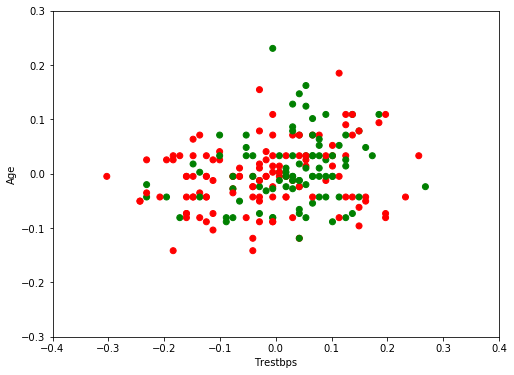

In [6]:
color = ['green' if i==1 else 'red' for i in Y_train]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=color)

plt.xlabel('Trestbps')
plt.ylabel('Age')
plt.xlim(-0.4, 0.4)
plt.ylim(-0.3, 0.3)
plt.show()

### SVM Model Training 

In [7]:
def rbf_kernel(x1,x2,degree=1):
    return ((np.dot(x1.T, x2) + 1)**degree)


def predict_Test_Set(X, Y, alpha, b, T_test, sigma):
    res = np.zeros((T_test.shape[0]))
    
    for i in range(X_test.shape[0]):
        for j in range(X.shape[0]):
            res[i] += (alpha[j]*Y[j]*rbf_kernel(X[j,:], X_test[i,:], sigma))
            
        res[i] += b
    
    return res

def predict(X,Y,alpha,b,x,sigma):
    '''
    Input : 
        X     - Training Set
        Y     - Training Set Labels
        Alpha - Langrange Multiplier
        b     - Bias 
        x     - Point under inspection
        sigma - sigma
    Return :
        res   - Wi*X + bi
    '''
    result=0.0
    for i in range(X.shape[0]):
        result += (alpha[i]*Y[i]*rbf_kernel(X[i,:] , x,sigma))
        
    return result + b


def SMO(X,Y,C=0.05,tol=math.pow(10,-3),max_passes=30,sigma=1):
    ''' 
    Input : 
        X   - Input Matrix.
        Y   - Label Matrix.
        C   - Regularization Term. 
        tol - Numerical Tolerance. 
        max_passes - max # of times to iterate wihtout changing alpha's

    Return : 
        Alpha   - Langrange Multiplier
        b       - Bias
    '''
    alpha = np.zeros(shape=(X.shape[0],1))
    b = 0.0
    E = np.zeros(shape=(X.shape[0],1))
    alpha_old = copy.deepcopy(alpha)
    passes = 0
    
    while(passes < max_passes):
        num_changed_alphas=0
        for i in range(X.shape[0]):
            E[i]=(predict(X,Y,alpha,b,X[i,:],sigma)-Y[i])

            if ( (-Y[i]*E[i]>tol and alpha[i]<C) or (Y[i]*E[i]>tol and alpha[i]>0) ):
                j=i
                while j==i:
                    j=random.randrange(X.shape[0])

                E[j] = (predict(X,Y,alpha,b,X[j,:],sigma)-Y[j])

                alpha_old[i], alpha_old[j] = alpha[i], alpha[j]

                # calculating L and H
                if(Y[i]!=Y[j]):
                    L = max(0,alpha[j]-alpha[i])
                    H = min(C,C+alpha[j]-alpha[i])
                else:
                    L = max(0,alpha[i]+alpha[j]-C)
                    H = min(C,alpha[i]+alpha[j])

                if(L == H): continue
                
                # Find the ETA
                eta = 2*rbf_kernel(X[i,:],X[j,:],sigma)
                eta=eta-rbf_kernel(X[i,:],X[i,:],sigma)
                eta=eta-rbf_kernel(X[j,:],X[j,:],sigma)

                if(eta >= 0): continue

                alpha[j] = alpha_old[j] - (Y[j]*(E[i]-E[j]))/eta

                if (alpha[j] > H): alpha[j] = H
                elif (alpha[j] < L): alpha[j] = L
                else: pass

                if(abs(alpha[j]-alpha_old[j]) < tol): continue
                
                # Update alpha
                alpha[i] += (Y[i]*Y[j]*(alpha_old[j] - alpha[j]))

                ii = rbf_kernel(X[i,:], X[i,:], sigma)
                ij = rbf_kernel(X[i,:], X[j,:], sigma)
                jj = rbf_kernel(X[j,:], X[j,:], sigma)
                
                # Calculate the bias
                b1 = b - E[i] - (Y[i]*ii*(alpha[i]-alpha_old[i])) - (Y[j]*ij*(alpha[j]-alpha_old[j]))
                b2 = b - E[j] - (Y[i]*ij*(alpha[i]-alpha_old[i])) - (Y[j]*jj*(alpha[j]-alpha_old[j]))
                   
                if (alpha[i] > 0 and alpha[i] < C): b = b1
                elif (alpha[j] > 0 and alpha[j] < C): b = b2
                else: b = (b1+b2)/2.0

                num_changed_alphas += 1
                
        if (num_changed_alphas == 0):
            passes+=1
            print(passes, end=' ')
        else: 
            passes=0
            clear_output(wait=True) # to see its progress in each pass

    return alpha, b

In [8]:
alpha, b = SMO(X_train_norm, Y_train)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

### Model Testing

In [9]:
res = predict_Test_Set(X_train_norm, Y_train, alpha, b, X_test, 1)
res_norm = Normalize(res, -1, 1)

result = (res_norm < 0)
test = (Y_test==-1)

sum = 0
for i in range(result.shape[0]):
    sum += 1*(result[i]==test[i])
    
print('Test Set Accuracy = ', round(100*sum/91, 4), '%')

Test Set Accuracy =  63.7363 %
